<a href="https://colab.research.google.com/github/yzm9393/swineBRET-ICD/blob/main/05_Train_Final_SwineBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Connect to Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


## 2. Import relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re


## 3. Configuration

In [ ]:
# --- Configuration ---
# The large dataset with machine-generated "soft" labels (probabilities)
PSEUDO_LABELED_FILE = '/content/drive/My Drive/Swine_project/pseudo_label.csv'

# The small dataset with "gold standard" human labels for validation
GOLD_STANDARD_FILE = '/content/drive/My Drive/Swine_project/annotated_gold_standard_processed.csv'

# The final, ordered list of modeling labels
FINAL_MODELING_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[08] Diseases of the nervous system',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[14] Diseases of the skin',
    '[15] Diseases of the musculoskeletal system or connective tissue',
    '[18] Pregnancy, childbirth or the puerperium',
    '[19] Certain conditions originating in the perinatal period',
    'Monitoring',
    'Unknown',
    'Symptoms not classified elsewhere'
]

PROCESSED_TEXT_COLUMN = 'anonymized_text_for_ml'

## 4. Convert train and validation datasets to Hugging Face format

In [ ]:
import pandas as pd
import numpy as np
import ast
from datasets import Dataset

# --- Load Training Data (Pseudo-Labeled) ---
df_pseudo = pd.read_csv(PSEUDO_LABELED_FILE)

# Prepare the soft labels (probabilities) as the target 'y'
pseudo_label_cols = [col for col in df_pseudo.columns if 'pseudo_label_' in col]

# Force the text column to be a string and fill any NaN with an empty string
train_texts = df_pseudo[PROCESSED_TEXT_COLUMN].astype(str).fillna('').tolist()
# ---------------------------------------------

train_labels = df_pseudo[pseudo_label_cols].values.astype(np.float32)


# --- Load Validation Data (Gold-Standard) ---
df_gold = pd.read_csv(GOLD_STANDARD_FILE)

# Convert the label vector from a string back into a list
df_gold['labels'] = df_gold['expert_labels_vector'].apply(ast.literal_eval)

# Apply the same robust string conversion here
val_texts = df_gold[PROCESSED_TEXT_COLUMN].astype(str).fillna('').tolist()
# ---------------------------------------------

val_labels = np.array(df_gold['labels'].tolist()).astype(np.float32)


# --- Convert to Hugging Face Dataset objects ---
# This will now work without the TypeError
train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})

print("Successfully created Hugging Face Dataset objects.")


Successfully created Hugging Face Dataset objects.


##5. Loads the pre-trained havocy28/VetBERT model
 The model uses a custom PyTorch class, VetBERTForMultiLabel, to add a new, untrained classification layer on top. This new layer is perfectly sized for 11 final modeling labels.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch

# Load base VetBERT
BASE_MODEL_NAME = "havocy28/VetBERT"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModel.from_pretrained(BASE_MODEL_NAME)

# Define label set
FINAL_MODELING_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[08] Diseases of the nervous system',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[14] Diseases of the skin',
    '[15] Diseases of the musculoskeletal system or connective tissue',
    '[18] Pregnancy, childbirth or the puerperium',
    '[19] Certain conditions originating in the perinatal period',
    'Monitoring',
    'Unknown',
    'Symptoms not classified elsewhere'
]

# Custom wrapper
class VetBERTForMultiLabel(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.bert = base_model
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)

# Instantiate model
model = VetBERTForMultiLabel(base_model, num_labels=len(FINAL_MODELING_LABELS))
print("✅ Model is ready for fine-tuning.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

✅ Model is ready for fine-tuning.


## 6. Tokenize Text
Using the VetBERT tokenizer, it converts all the text into numerical inputs that the model can understand, ensuring every record is padded or truncated to a consistent length of 512 tokens.

In [ ]:
import pandas as pd
import numpy as np
import ast
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import f1_score, roc_auc_score

# --- 1. Configuration ---
# The large dataset with machine-generated "soft" labels (probabilities)
PSEUDO_LABELED_FILE = '/content/drive/My Drive/Swine_project/pseudo_label.csv'

# The small dataset with "gold standard" human labels for validation
GOLD_STANDARD_FILE = '/content/drive/My Drive/Swine_project/annotated_gold_standard_processed.csv'

BASE_MODEL_NAME = "havocy28/VetBERT"
PROCESSED_TEXT_COLUMN = 'anonymized_text_for_ml'

FINAL_MODELING_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[08] Diseases of the nervous system',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[14] Diseases of the skin',
    '[15] Diseases of the musculoskeletal system or connective tissue',
    '[18] Pregnancy, childbirth or the puerperium',
    '[19] Certain conditions originating in the perinatal period',
    'Monitoring',
    'Unknown',
    'Symptoms not classified elsewhere'
]
# --- 2. Load and Prepare Full Datasets ---
# Load Training Data (Pseudo-Labeled)
df_pseudo = pd.read_csv(PSEUDO_LABELED_FILE)
pseudo_label_cols = [col for col in df_pseudo.columns if 'pseudo_label_' in col]
train_texts = df_pseudo[PROCESSED_TEXT_COLUMN].astype(str).fillna('').tolist()
train_labels = df_pseudo[pseudo_label_cols].values.astype(np.float32)

# Load Validation Data (Gold-Standard)
df_gold = pd.read_csv(GOLD_STANDARD_FILE)
df_gold['labels'] = df_gold['expert_labels_vector'].apply(ast.literal_eval)
val_texts = df_gold[PROCESSED_TEXT_COLUMN].astype(str).fillna('').tolist()
val_labels = np.array(df_gold['labels'].tolist()).astype(np.float32)

# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})

# --- 3. Tokenization ---
print("--- Tokenizing Datasets ---")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512  # Explicitly set the max length
    )

train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
val_dataset_tokenized = val_dataset.map(tokenize_function, batched=True)
print("Tokenization complete.")

# --- 4. Load Model ---
model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=len(FINAL_MODELING_LABELS),
    problem_type="multi_label_classification"
)

--- Tokenizing Datasets ---


Map:   0%|          | 0/35058 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenization complete.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at havocy28/VetBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 7. Calculate class frequencies for weights loss function



In [ ]:
import torch
import pandas as pd
import numpy as np

# --- 1. Load your final modeling data ---
df_gold = pd.read_csv('/content/drive/My Drive/Swine_project/annotated_gold_standard_processed.csv')

# --- 2. Define the CORRECTED list of labels ---
# This version has no extra spaces or newline characters.
FINAL_MODELING_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[08] Diseases of the nervous system',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[14] Diseases of the skin',
    '[15] Diseases of the musculoskeletal system or connective tissue',
    '[18] Pregnancy, childbirth or the puerperium',
    '[19] Certain conditions originating in the perinatal period',
    'Monitoring',
    'Unknown',
    'Symptoms not classified elsewhere'
]

# --- 3. Calculate the Class Weights ---
# This code will now work correctly.
print("Calculating class weights for the loss function...")

# Calculate the number of positive samples for each class
positives = df_gold[FINAL_MODELING_LABELS].sum()
negatives = len(df_gold) - positives

# Calculate pos_weight for each class
pos_weight = negatives / positives

# Convert to a PyTorch tensor
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)

print("\nCalculated Positive Weights:")
print(pos_weight)

Calculating class weights for the loss function...

Calculated Positive Weights:
[01] Certain infectious or parasitic diseases                        7.097166
[08] Diseases of the nervous system                                 49.000000
[12] Diseases of the respiratory system                              9.362694
[13] Diseases of the digestive system                                7.733624
[14] Diseases of the skin                                           42.478261
[15] Diseases of the musculoskeletal system or connective tissue    35.363636
[18] Pregnancy, childbirth or the puerperium                        43.444444
[19] Certain conditions originating in the perinatal period         36.735849
Monitoring                                                           2.906250
Unknown                                                              1.865330
Symptoms not classified elsewhere                                    4.681818
dtype: float64


## 8. Define the performance evaluation metrices
1. Applies sigmoid activation to model outputs (predictions.predictions) to convert logits into probabilities.

2. Binarizes predictions at a threshold of 0.5, producing y_pred for comparison against true labels (y_true).

3. Computes overall metrics:

* Micro-averaged F1-score (treats all label predictions equally).

* Subset accuracy (all labels for a sample must match to count as correct).

* Computes per-label metrics for each label in FINAL_MODELING_LABELS:

* F1-score (handles zero divisions safely).

* Accuracy (per label).

* Baseline accuracy as the frequency of the majority class (class imbalance reference).

In [ ]:
# --- Define Comprehensive Metrics Function ---
def compute_comprehensive_metrics(predictions):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions.predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs > 0.5)] = 1
    y_true = predictions.label_ids

    # Overall Metrics
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    overall_accuracy = accuracy_score(y_true=y_true, y_pred=y_pred) # Subset accuracy

    metrics = {'f1_micro': f1_micro, 'overall_accuracy': overall_accuracy}

    # Per-Label Metrics
    for i in range(len(FINAL_MODELING_LABELS)):
        label_name = FINAL_MODELING_LABELS[i]
        safe_label_name = re.sub(r'[\W_]+', '', label_name).lower()

        # Individual F1 Score
        f1 = f1_score(y_true=y_true[:, i], y_pred=y_pred[:, i], zero_division=0)
        metrics[f'f1_{safe_label_name}'] = f1

        # Individual Accuracy
        accuracy = accuracy_score(y_true=y_true[:, i], y_pred=y_pred[:, i])
        metrics[f'accuracy_{safe_label_name}'] = accuracy

        # Majority Class Frequency (Baseline Accuracy)
        majority_freq = 1 - (np.sum(y_true[:, i]) / len(y_true[:, i]))
        metrics[f'baseline_acc_{safe_label_name}'] = majority_freq

    return metrics

## 9. Custom Trainer with class weights
1. Custom Trainer subclass that overrides compute_loss to apply class-weighted loss.

2. Removes labels from inputs, runs forward pass to get logits.

3. Uses BCEWithLogitsLoss with precomputed pos_weight to handle class imbalance.

4. Returns loss (and optionally model outputs) for backpropagation.

In [ ]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # ----------------------

        # Get the labels from the input batch
        labels = inputs.pop("labels")

        # Forward pass to get model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.logits

        # Define the loss function with your calculated weights
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(self.model.device))

        # Calculate the loss
        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss


## 10. Define training arguments

1. Trains for 3 epochs with a batch size of 16 for both training and evaluation.

2. Uses a low learning rate (2e-5) for stable fine-tuning.

3. Applies weight decay (0.01) to help prevent overfitting.

4. Warms up the learning rate over the first 500 steps.

5. Evaluates and saves the model every 563 steps.

6. Enables mixed-precision training (fp16) for faster, memory-efficient runs.

7. Loads the best model at the end based on eval_f1_micro.

8. Disables reporting to external services.

In [ ]:
from transformers import TrainingArguments
full_training_args = TrainingArguments(
    output_dir='./results_full_run_weighted',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # --- KEY CHANGES ---
    learning_rate=2e-5,       # Use a lower learning rate for more stable training
    weight_decay=0.01,        # Helps prevent overfitting
    warmup_steps=500,         # Gradually increases the learning rate at the start
    # -------------------
    eval_strategy="steps",
    eval_steps=563,
    save_steps=563,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_micro", # Must start with "eval_"
    report_to="none",
)

## 11. Lauch Training and save the best model

In [ ]:

# Initialize the Trainer, passing the metrics function to it
trainer = WeightedLossTrainer( # Or the standard Trainer
    model=model,
    args=full_training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=val_dataset_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_comprehensive_metrics, # Pass the function here
)

# Launch the training
trainer.train()

# Save the final model
trainer.save_model("./final_swinebert_model")

/tmp/ipython-input-204279766.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer( # Or the standard Trainer
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss,Validation Loss,F1 Micro,Overall Accuracy,F1 01certaininfectiousorparasiticdiseases,Accuracy 01certaininfectiousorparasiticdiseases,Baseline Acc 01certaininfectiousorparasiticdiseases,F1 08diseasesofthenervoussystem,Accuracy 08diseasesofthenervoussystem,Baseline Acc 08diseasesofthenervoussystem,F1 12diseasesoftherespiratorysystem,Accuracy 12diseasesoftherespiratorysystem,Baseline Acc 12diseasesoftherespiratorysystem,F1 13diseasesofthedigestivesystem,Accuracy 13diseasesofthedigestivesystem,Baseline Acc 13diseasesofthedigestivesystem,F1 14diseasesoftheskin,Accuracy 14diseasesoftheskin,Baseline Acc 14diseasesoftheskin,F1 15diseasesofthemusculoskeletalsystemorconnectivetissue,Accuracy 15diseasesofthemusculoskeletalsystemorconnectivetissue,Baseline Acc 15diseasesofthemusculoskeletalsystemorconnectivetissue,F1 18pregnancychildbirthorthepuerperium,Accuracy 18pregnancychildbirthorthepuerperium,Baseline Acc 18pregnancychildbirthorthepuerperium,F1 19certainconditionsoriginatingintheperinatalperiod,Accuracy 19certainconditionsoriginatingintheperinatalperiod,Baseline Acc 19certainconditionsoriginatingintheperinatalperiod,F1 Monitoring,Accuracy Monitoring,Baseline Acc Monitoring,F1 Unknown,Accuracy Unknown,Baseline Acc Unknown,F1 Symptomsnotclassifiedelsewhere,Accuracy Symptomsnotclassifiedelsewhere,Baseline Acc Symptomsnotclassifiedelsewhere
563,0.564400,0.695142,0.460353,0.326000,0.384483,0.643000,0.876500,0.099857,0.684500,0.980000,0.457074,0.775500,0.903500,0.452138,0.731000,0.885500,0.192394,0.819500,0.977000,0.163142,0.723000,0.972500,0.189815,0.825000,0.977500,0.161137,0.734500,0.973500,0.801382,0.885000,0.744000,0.777943,0.851000,0.651000,0.596273,0.772500,0.824000
1126,0.517500,0.609093,0.513554,0.305000,0.437073,0.711500,0.876500,0.112397,0.731500,0.980000,0.562691,0.857000,0.903500,0.510983,0.788500,0.885500,0.222222,0.846000,0.977000,0.172249,0.740500,0.972500,0.184946,0.810500,0.977500,0.244131,0.839000,0.973500,0.821747,0.900000,0.744000,0.812940,0.867000,0.651000,0.623352,0.800000,0.824000
1689,0.501600,0.577852,0.552185,0.353500,0.501818,0.794500,0.876500,0.128906,0.777000,0.980000,0.586885,0.874000,0.903500,0.549313,0.819500,0.885500,0.299320,0.897000,0.977000,0.220374,0.812500,0.972500,0.183761,0.809000,0.977500,0.208000,0.802000,0.973500,0.822796,0.900500,0.744000,0.831325,0.874000,0.651000,0.652219,0.831500,0.824000
2252,0.491900,0.575054,0.531637,0.338500,0.469584,0.751500,0.876500,0.111293,0.728500,0.980000,0.569659,0.861000,0.903500,0.529268,0.807000,0.885500,0.233766,0.852500,0.977000,0.191336,0.776000,0.972500,0.198614,0.826500,0.977500,0.245192,0.843000,0.973500,0.824156,0.901000,0.744000,0.828591,0.876500,0.651000,0.629451,0.807500,0.824000
2815,0.484600,0.566062,0.540964,0.344500,0.472222,0.753000,0.876500,0.136000,0.784000,0.980000,0.577778,0.867000,0.903500,0.538272,0.813000,0.885500,0.288525,0.891500,0.977000,0.185053,0.771000,0.972500,0.211302,0.839500,0.977500,0.210101,0.804500,0.973500,0.822496,0.899000,0.744000,0.821277,0.874000,0.651000,0.647716,0.826500,0.824000
3378,0.482100,0.556358,0.560283,0.340500,0.485549,0.777500,0.876500,0.131528,0.775500,0.980000,0.621762,0.890500,0.903500,0.586445,0.850500,0.885500,0.255814,0.872000,0.977000,0.205941,0.799500,0.972500,0.206388,0.838500,0.977500,0.246377,0.844000,0.973500,0.825737,0.902500,0.744000,0.828051,0.872500,0.651000,0.659067,0.835500,0.824000
3941,0.483100,0.559670,0.538480,0.315500,0.484256,0.762500,0.876500,0.128913,0.763500,0.980000,0.586371,0.869500,0.903500,0.537608,0.812500,0.885500,0.260116,0.872000,0.977000,0.177852,0.755000,0.972500,0.181034,0.810000,0.977500,0.232662,0.828500,0.973500,0.827648,0.904000,0.744000,0.828435,0.874500,0.651000,0.648111,0.823000,0.824000
4504,0.484600,0.556670,0.536759,0.315000,0.477322,0.758000,0.876500,0.121417,0.739500,0.980000,0.569678,0.859500,0.903500,0.556122,0.826000,0.885500,0.247191,0.866000,0.977000,0.182759,0.763000,0.972500,0.186253,0.816500,0.977500,0.223176,0.819000,0.973500,0.83198

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

## 12. Optimal probability threshold for each label on the validation set to maximize its F1 score.

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# This script runs AFTER your model is trained.

# --- 1. Get Predictions on the Validation Set ---
print("--- Finding Optimal Decision Thresholds ---")
predictions_output = trainer.predict(val_dataset_tokenized)
logits = predictions_output.predictions
y_true = predictions_output.label_ids

# Convert logits to probabilities
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))

# --- 2. Find the Best Threshold for Each Label ---
optimal_thresholds = {}
print("\nOptimal Thresholds per Label:")

for i, label_name in enumerate(FINAL_MODELING_LABELS):
    best_f1 = 0
    best_thresh = 0.5  # Default threshold

    # Test thresholds from 0.05 to 0.95
    for threshold in np.arange(0.01, 1.0, 0.01):
        # --- THIS IS THE FIX ---
        # The comparison creates a boolean Tensor. Use .int() to convert it to 0s and 1s.
        y_pred_temp = (probs[:, i] >= threshold).int()
        # ----------------------

        # Calculate the F1 score
        f1 = f1_score(y_true[:, i], y_pred_temp, zero_division=0)

        # If this threshold gives a better F1 score, update our best values
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = threshold

    optimal_thresholds[label_name] = best_thresh
    print(f"- {label_name}: {best_thresh:.2f} (Best F1: {best_f1:.4f})")

print("\nOptimal thresholds stored in the 'optimal_thresholds' dictionary.")

--- Finding Optimal Decision Thresholds ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Optimal Thresholds per Label:
- [01] Certain infectious or parasitic diseases: 0.73 (Best F1: 0.5709)
- [08] Diseases of the nervous system: 0.88 (Best F1: 0.4301)
- [12] Diseases of the respiratory system: 0.80 (Best F1: 0.7482)
- [13] Diseases of the digestive system: 0.85 (Best F1: 0.7156)
- [14] Diseases of the skin: 0.86 (Best F1: 0.5077)
- [15] Diseases of the musculoskeletal system or connective tissue: 0.83 (Best F1: 0.5032)
- [18] Pregnancy, childbirth or the puerperium: 0.89 (Best F1: 0.6526)
- [19] Certain conditions originating in the perinatal period: 0.89 (Best F1: 0.4815)
- Monitoring: 0.69 (Best F1: 0.8505)
- Unknown: 0.54 (Best F1: 0.8312)
- Symptoms not classified elsewhere: 0.70 (Best F1: 0.6828)

Optimal thresholds stored in the 'optimal_thresholds' dictionary.


## 13. Use the final model to make prediction on test data set

In [ ]:
import os

# Add this line to disable Weights & Biases
os.environ["WANDB_DISABLED"] = "true"
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from sklearn.metrics import classification_report

# --- 1. Configuration ---
# The path to your saved, fine-tuned model
FINAL_MODEL_PATH = "./final_swinebert_model"
# The new, annotated Excel file for the test set
ANNOTATED_TEST_FILE = '/content/drive/My Drive/Swine_project/final_test_set_cleaned_zp.xlsx'
# The column with the clinical text in the test file
TEXT_COLUMN = 'anonymized_text_for_ml'

# The final, ordered list of modeling labels (must match your trained model)
FINAL_MODELING_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[08] Diseases of the nervous system',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[14] Diseases of the skin',
    '[15] Diseases of the musculoskeletal system or connective tissue',
    '[18] Pregnancy, childbirth or the puerperium',
    '[19] Certain conditions originating in the perinatal period',
    'Monitoring',
    'Unknown',
    'Symptoms not classified elsewhere'
]
# This is the dictionary of optimal thresholds you just created
optimal_thresholds = {
    '[01] Certain infectious or parasitic diseases': 0.73,
    '[08] Diseases of the nervous system': 0.88,
    '[12] Diseases of the respiratory system': 0.80,
    '[13] Diseases of the digestive system': 0.85,
    '[14] Diseases of the skin': 0.86,
    '[15] Diseases of the musculoskeletal system or connective tissue': 0.83,
    '[18] Pregnancy, childbirth or the puerperium': 0.89,
    '[19] Certain conditions originating in the perinatal period': 0.89,
    'Monitoring': 0.69,
    'Unknown': 0.54,
    'Symptoms not classified elsewhere': 0.70,
}

# --- 2. Load the Trained Model and Tokenizer ---
print(f"--- Loading final model from '{FINAL_MODEL_PATH}' ---")
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(FINAL_MODEL_PATH)

# --- 3. Load and Prepare the Test Set ---
print(f"\n--- Loading and Preparing Annotated Test Set ---")
df_test = pd.read_excel(ANNOTATED_TEST_FILE)

df_test_processed = df_test.copy()
PROCESSED_TEXT_COLUMN = TEXT_COLUMN

# Convert labels to multi-hot vector (the "ground truth")
for col in FINAL_MODELING_LABELS:
    if col in df_test_processed.columns:
        df_test_processed[col] = df_test_processed[col].notna().astype(int)
    else:
        df_test_processed[col] = 0
y_true = df_test_processed[FINAL_MODELING_LABELS].values

# Tokenize the test text
test_texts = df_test_processed[PROCESSED_TEXT_COLUMN].astype(str).fillna('').tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
test_dataset = Dataset.from_dict(test_encodings)

# --- 4. Make Predictions ---
print("\n--- Making predictions on the test set ---")
# We use a dummy Trainer just to run the prediction
trainer = Trainer(model=model)
predictions_output = trainer.predict(test_dataset)

# Get the raw outputs (logits) and convert to probabilities
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(predictions_output.predictions))

# --- 5. Apply Optimal Thresholds ---
print("\n--- Applying optimal thresholds ---")
y_pred = np.zeros(probs.shape)

for i, label_name in enumerate(FINAL_MODELING_LABELS):
    threshold = optimal_thresholds.get(label_name, 0.5)

    # The comparison creates a boolean Tensor. Use .int() to convert it to 0s and 1s.
    predictions_for_label = (probs[:, i] >= threshold).int()
    # ----------------------

    # Convert the PyTorch tensor for this label to a NumPy array before assigning
    y_pred[:, i] = predictions_for_label.numpy()

# --- 6. Generate and Display the Final Performance Report ---
print("\n" + "="*80)
print("--- FINAL MODEL PERFORMANCE ON UNSEEN TEST SET ---")
print("="*80)

final_report = classification_report(
    y_true,
    y_pred,
    target_names=FINAL_MODELING_LABELS,
    zero_division=0
)

print(final_report)

--- Loading final model from './final_swinebert_model' ---

--- Loading and Preparing Annotated Test Set ---


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



--- Making predictions on the test set ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- Applying optimal thresholds ---

--- FINAL MODEL PERFORMANCE ON UNSEEN TEST SET ---
                                                                  precision    recall  f1-score   support

                   [01] Certain infectious or parasitic diseases       0.61      0.37      0.46       233
                             [08] Diseases of the nervous system       0.14      0.18      0.16        17
                         [12] Diseases of the respiratory system       0.63      0.77      0.69        82
                           [13] Diseases of the digestive system       0.81      0.57      0.67       138
                                       [14] Diseases of the skin       0.17      0.35      0.23        17
[15] Diseases of the musculoskeletal system or connective tissue       0.24      0.43      0.31        21
                    [18] Pregnancy, childbirth or the puerperium       0.70      0.58      0.64        24
     [19] Certain conditions originating in the perinatal peri

## 14. Use the final model to make predictions on the six most clinically important labels

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Configuration ---
# This must be the full, ordered list of 11 labels your model was trained on
FINAL_MODELING_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[08] Diseases of the nervous system',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[14] Diseases of the skin',
    '[15] Diseases of the musculoskeletal system or connective tissue',
    '[18] Pregnancy, childbirth or the puerperium',
    '[19] Certain conditions originating in the perinatal period',
    'Monitoring',
    'Unknown',
    'Symptoms not classified elsewhere'
]

# The 6 "most clinically meaningful" labels you selected
CLINICALLY_MEANINGFUL_LABELS = [
    '[01] Certain infectious or parasitic diseases',
    '[12] Diseases of the respiratory system',
    '[13] Diseases of the digestive system',
    '[18] Pregnancy, childbirth or the puerperium',
    'Monitoring',
    'Unknown'
]


# --- 2. Filter for the 6 Clinically Meaningful Labels ---
print("--- Filtering results for the 6 clinically meaningful labels ---")
# Find the index position of each label in the full list
meaningful_indices = [FINAL_MODELING_LABELS.index(label) for label in CLINICALLY_MEANINGFUL_LABELS]

# Slice the arrays to keep only the data for these 6 labels
y_true_meaningful = y_true[:, meaningful_indices]
y_pred_meaningful = y_pred[:, meaningful_indices]
print("Filtering complete.")


# --- 3. Generate the Comprehensive Report ---
print("\n" + "="*80)
print("--- FINAL MODEL PERFORMANCE ON 6 CLINICALLY MEANINGFUL LABELS ---")
print("="*80)

# Calculate overall metrics using the filtered data
report_dict = classification_report(y_true_meaningful, y_pred_meaningful, target_names=CLINICALLY_MEANINGFUL_LABELS, output_dict=True, zero_division=0)

# Create a detailed, per-label report DataFrame
results_data = []
for i, label_name in enumerate(CLINICALLY_MEANINGFUL_LABELS):
    # Calculate accuracy and baseline frequency for this label
    accuracy = accuracy_score(y_true_meaningful[:, i], y_pred_meaningful[:, i])
    majority_freq = 1 - (np.sum(y_true_meaningful[:, i]) / len(y_true_meaningful[:, i]))

    # Extract precision, recall, and f1-score from the report dictionary
    precision = report_dict[label_name]['precision']
    recall = report_dict[label_name]['recall']
    f1_score_val = report_dict[label_name]['f1-score']

    # Round all metrics to 2 decimal places
    results_data.append({
        'Label': label_name,
        'F1-Score': round(f1_score_val, 2),
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'Model_Accuracy': f"{accuracy:.2%}",
        'Majority_Class_Freq': f"{majority_freq:.2%}"
    })

results_df = pd.DataFrame(results_data)

# --- 4. Display Results ---
print("\n--- Per-Label Performance (6 Clinically Meaningful Labels) ---")
print(results_df.to_string())

print("\n\n--- Overall Performance (Averages for 6 Clinically Meaningful Labels) ---")
# Extract and round average scores from the report dictionary
micro_f1 = report_dict['micro avg']['f1-score']
micro_prec = report_dict['micro avg']['precision']
micro_rec = report_dict['micro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']
macro_prec = report_dict['macro avg']['precision']
macro_rec = report_dict['macro avg']['recall']

print(f"Overall Micro F1-Score: {micro_f1:.2f}")
print(f"Overall Micro Precision: {micro_prec:.2f}")
print(f"Overall Micro Recall: {micro_rec:.2f}")
print("-" * 20)
print(f"Overall Macro F1-Score: {macro_f1:.2f}")
print(f"Overall Macro Precision: {macro_prec:.2f}")
print(f"Overall Macro Recall: {macro_rec:.2f}")
print("="*80)


--- Filtering results for the 6 clinically meaningful labels ---
Filtering complete.

--- FINAL MODEL PERFORMANCE ON 6 CLINICALLY MEANINGFUL LABELS ---

--- Per-Label Performance (6 Clinically Meaningful Labels) ---
                                           Label  F1-Score  Precision  Recall Model_Accuracy Majority_Class_Freq
0  [01] Certain infectious or parasitic diseases      0.46       0.61    0.37         79.80%              76.70%
1        [12] Diseases of the respiratory system      0.69       0.63    0.77         94.40%              91.80%
2          [13] Diseases of the digestive system      0.67       0.81    0.57         92.30%              86.20%
3   [18] Pregnancy, childbirth or the puerperium      0.64       0.70    0.58         98.40%              97.60%
4                                     Monitoring      0.84       0.85    0.82         91.00%              72.00%
5                                        Unknown      0.78       0.75    0.82         85.90%              

## 15. Visualization of F1 score on all 11 labels

Chart for all 11 labels saved as 'all_11_labels_f1_scores_vertical.png'


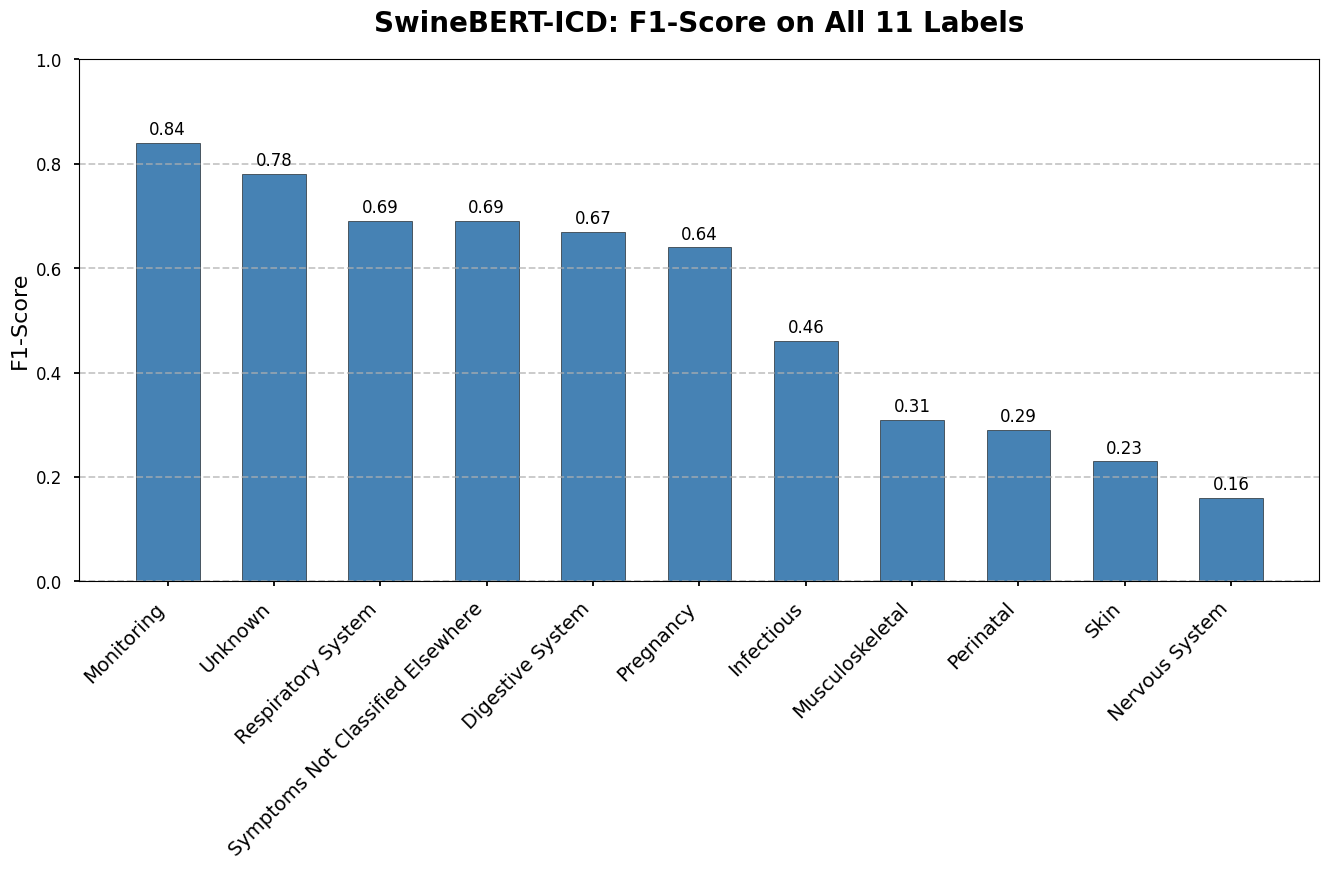

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Your Full Results Data ---
data_all = {
    'Label': [
        '[01] Certain infectious or parasitic diseases', '[08] Diseases of the nervous system',
        '[12] Diseases of the respiratory system', '[13] Diseases of the digestive system',
        '[14] Diseases of the skin', '[15] Diseases of the musculoskeletal system or connective tissue',
        '[18] Pregnancy, childbirth or the puerperium', '[19] Certain conditions originating in the perinatal period',
        'Monitoring', 'Unknown', 'Symptoms not classified elsewhere'
    ],
    'F1-Score': [0.46, 0.16, 0.69, 0.67, 0.23, 0.31, 0.64, 0.29, 0.84, 0.78, 0.69]
}
df_all = pd.DataFrame(data_all).sort_values('F1-Score', ascending=False)

# --- 2. Clean Up Long Label Names for Display ---
df_all['Label_Short'] = df_all['Label'].str.replace(r'\[\d+\]\s*', '', regex=True)
df_all['Label_Short'] = df_all['Label_Short'].str.replace('Certain infectious or parasitic diseases', 'Infectious')
df_all['Label_Short'] = df_all['Label_Short'].str.replace('Diseases of the musculoskeletal system or connective tissue', 'Musculoskeletal')
df_all['Label_Short'] = df_all['Label_Short'].str.replace('Diseases of the ', '')
df_all['Label_Short'] = df_all['Label_Short'].str.replace('Certain conditions originating in the perinatal period', 'Perinatal')
df_all['Label_Short'] = df_all['Label_Short'].str.replace('Pregnancy, childbirth or the puerperium', 'Pregnancy')
df_all['Label_Short'] = df_all['Label_Short'].str.title()


# --- 3. Create the Vertical Bar Chart ---
plt.style.use('seaborn-v0_8-talk')
x_labels = df_all['Label_Short']
x = np.arange(len(x_labels)) # the label locations
width = 0.6 # the width of the bars

fig, ax = plt.subplots(figsize=(16, 9)) # Wider figure for better label spacing
bars = ax.bar(x, df_all['F1-Score'], width, label='F1-Score', color='#4682B4', edgecolor='black')

# --- 4. Add Labels, Title, and Formatting ---
ax.set_ylabel('F1-Score', fontsize=16)
ax.set_title('SwineBERT-ICD: F1-Score on All 11 Labels', fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 1.0) # F1-score is between 0 and 1

# Add data labels on top of the bars
ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=12)

# Adjust layout to prevent labels from being cut off
plt.subplots_adjust(bottom=0.3)

plt.savefig('all_11_labels_f1_scores_vertical.png', dpi=300)
print("Chart for all 11 labels saved as 'all_11_labels_f1_scores_vertical.png'")

## 16. Performance evaluation on the six clinically important labels


Chart with your specified colors saved as 'core_6_performance_final_colors.png'


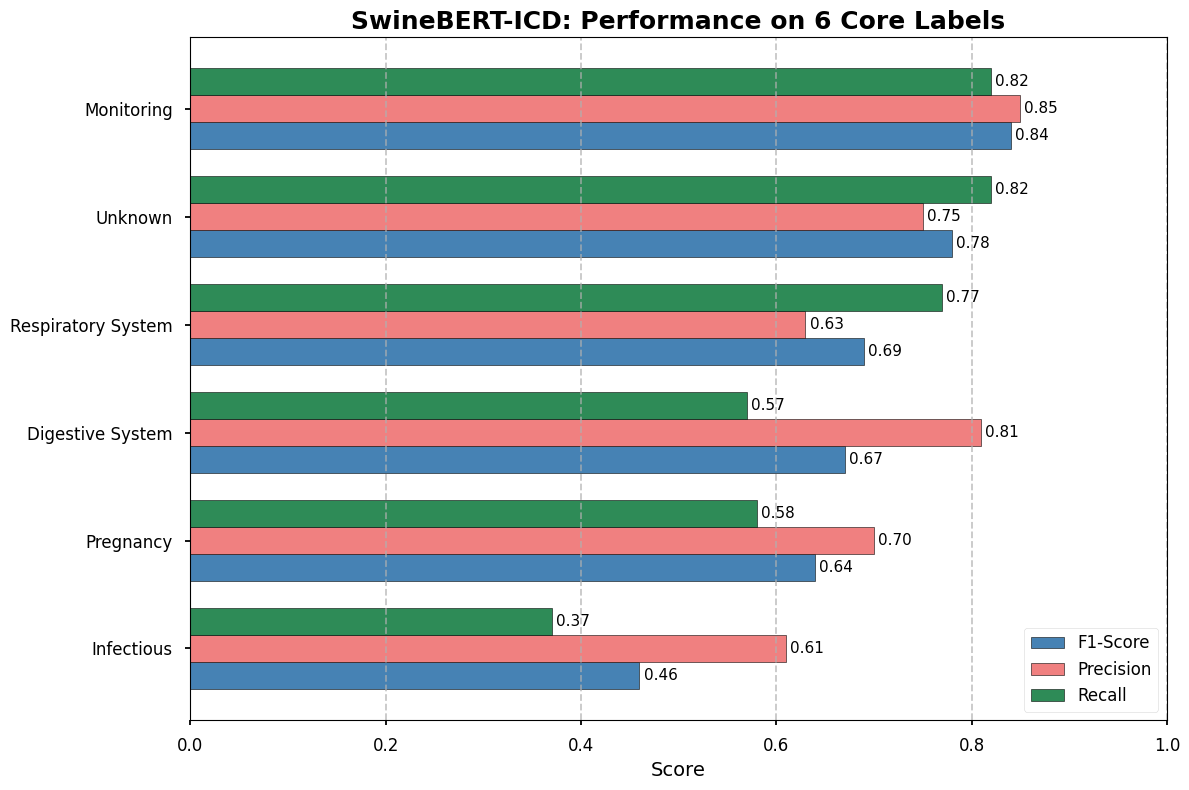

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Your "Core 6" Results Data ---
data_core = {
    'Label': [
        '[01] Certain infectious or parasitic diseases',
        '[12] Diseases of the respiratory system',
        '[13] Diseases of the digestive system',
        '[18] Pregnancy, childbirth or the puerperium',
        'Monitoring',
        'Unknown'
    ],
    'F1-Score': [0.46, 0.69, 0.67, 0.64, 0.84, 0.78],
    'Precision': [0.61, 0.63, 0.81, 0.70, 0.85, 0.75],
    'Recall': [0.37, 0.77, 0.57, 0.58, 0.82, 0.82]
}
df_core = pd.DataFrame(data_core).sort_values('F1-Score', ascending=True)

# --- 2. Clean Up and Capitalize Label Names ---
df_core['Label_Short'] = df_core['Label'].str.replace(r'\[\d+\]\s*', '', regex=True)
df_core['Label_Short'] = df_core['Label_Short'].str.replace('Certain infectious or parasitic diseases', 'Infectious')
df_core['Label_Short'] = df_core['Label_Short'].str.replace('Diseases of the ', '')
df_core['Label_Short'] = df_core['Label_Short'].str.replace('Pregnancy, childbirth or the puerperium', 'Pregnancy')
df_core['Label_Short'] = df_core['Label_Short'].str.title()

# --- 3. Create the Grouped Bar Chart ---
plt.style.use('seaborn-v0_8-talk')
y_labels = df_core['Label_Short']
y = np.arange(len(y_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))

# --- THIS IS THE CHANGE: Using your requested color scheme ---
rects1 = ax.barh(y - width, df_core['F1-Score'], width, label='F1-Score', color='#4682B4', edgecolor='black') # Blue
rects2 = ax.barh(y, df_core['Precision'], width, label='Precision', color='lightcoral', edgecolor='black')   # Pink/Red
rects3 = ax.barh(y + width, df_core['Recall'], width, label='Recall', color='seagreen', edgecolor='black')       # Green
# -----------------------------------------------------------

# --- 4. Add Labels, Title, and Legend ---
ax.set_xlabel('Score', fontsize=14)
ax.set_title('SwineBERT-ICD: Performance on 6 Core Labels', fontsize=18, fontweight='bold')
ax.set_yticks(y)
ax.set_yticklabels(y_labels, fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_xlim(0, 1)

ax.bar_label(rects1, fmt='%.2f', padding=3, fontsize=11)
ax.bar_label(rects2, fmt='%.2f', padding=3, fontsize=11)
ax.bar_label(rects3, fmt='%.2f', padding=3, fontsize=11)

fig.tight_layout()
plt.savefig('core_6_performance_final_colors.png', dpi=300)
print("\nChart with your specified colors saved as 'core_6_performance_final_colors.png'")

## 17. Sanity check:

 Compare the model accuracy against majority frequency class on the six most clinically important labels.

Chart saved as 'core_6_accuracy_comparison_vertical.png'


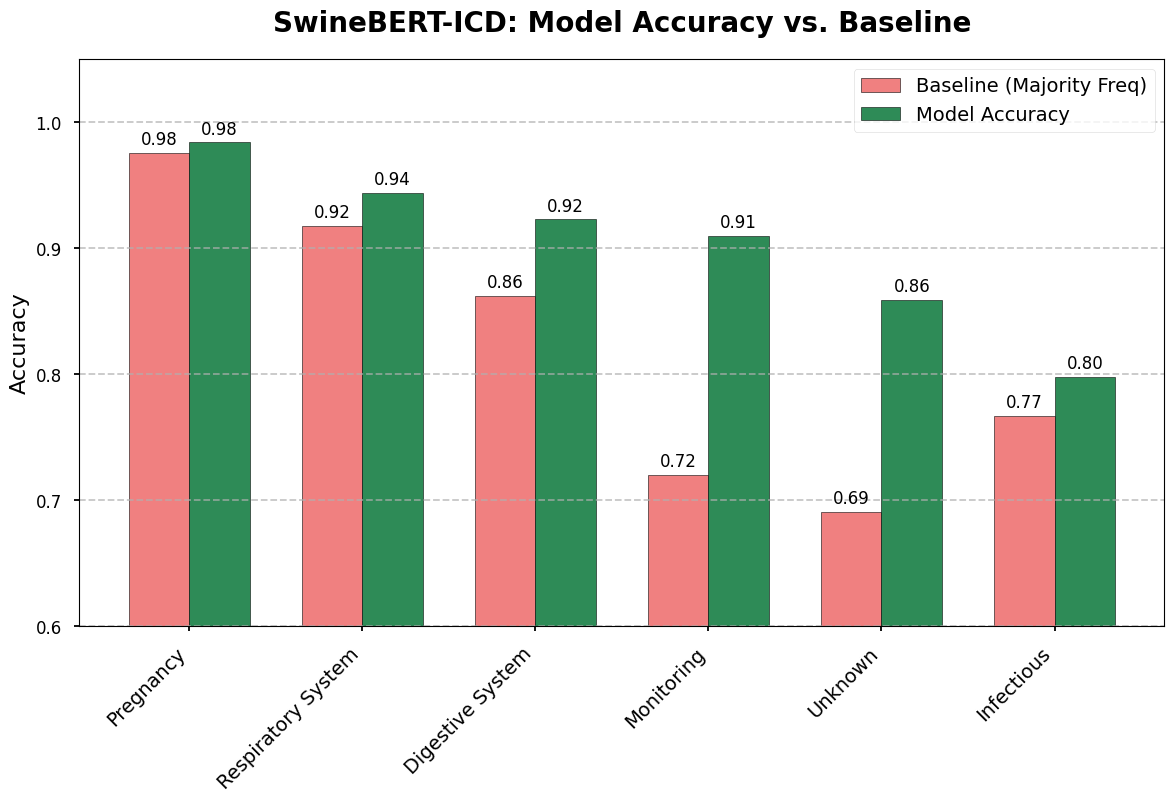

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Your Final Results Data ---
data_acc = {
    'Label': [
        '[01] Certain infectious or parasitic diseases',
        '[12] Diseases of the respiratory system',
        '[13] Diseases of the digestive system',
        '[18] Pregnancy, childbirth or the puerperium',
        'Monitoring',
        'Unknown'
    ],
    'Model_Accuracy': [0.798, 0.944, 0.923, 0.984, 0.910, 0.859],
    'Majority_Class_Freq': [0.767, 0.918, 0.862, 0.976, 0.720, 0.691]
}
df_acc = pd.DataFrame(data_acc).sort_values('Model_Accuracy', ascending=False)

# --- 2. Clean Up Long Label Names for Display ---
df_acc['Label_Short'] = df_acc['Label'].str.replace(r'\[\d+\]\s*', '', regex=True)
df_acc['Label_Short'] = df_acc['Label_Short'].str.replace('Certain infectious or parasitic diseases', 'Infectious')
df_acc['Label_Short'] = df_acc['Label_Short'].str.replace('Diseases of the ', '')
df_acc['Label_Short'] = df_acc['Label_Short'].str.replace('Pregnancy, childbirth or the puerperium', 'Pregnancy')
# --- THIS IS THE CHANGE ---
df_acc['Label_Short'] = df_acc['Label_Short'].str.title()
# --- 3. Create the Grouped Vertical Bar Chart ---
plt.style.use('seaborn-v0_8-talk')
x_labels = df_acc['Label_Short']
x = np.arange(len(x_labels)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(14, 9)) # Increased figure height for more space

# --- THIS IS THE CHANGE: Plot the baseline bar first (on the left) ---
rects1 = ax.bar(x - width/2, df_acc['Majority_Class_Freq'], width, label='Baseline (Majority Freq)', color='lightcoral', edgecolor='black')
rects2 = ax.bar(x + width/2, df_acc['Model_Accuracy'], width, label='Model Accuracy', color='seagreen', edgecolor='black')
# --------------------------------------------------------------------

# --- 4. Add Labels, Title, and Legend ---
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('SwineBERT-ICD: Model Accuracy vs. Baseline', fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x)
# --- THIS IS THE CHANGE: Increased font size for better visibility ---
ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=14)
# -------------------------------------------------------------------
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0.6, 1.05)

# Add data labels on top of the bars
ax.bar_label(rects1, fmt='%.2f', padding=3, fontsize=12)
ax.bar_label(rects2, fmt='%.2f', padding=3, fontsize=12)

# Adjust layout to prevent labels from being cut off
plt.subplots_adjust(bottom=0.25)

plt.savefig('core_6_accuracy_comparison_vertical.png', dpi=300)
print("Chart saved as 'core_6_accuracy_comparison_vertical.png'")